# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [ ]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

## Leitura, normalização e visualização dos dados

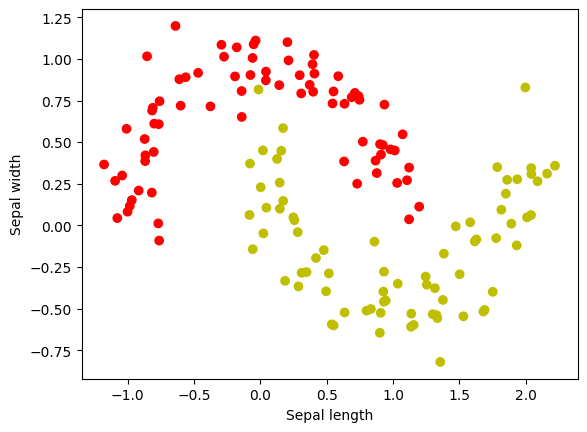

In [ ]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [ ]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [ ]:
# class Modelo(nn.Module):
#     def __init__(self):
#         super(Modelo, self).__init__()
#         self.dense = nn.Sequential(
#             nn.Linear(2, 5),
#             nn.ReLU(),
#             nn.Linear(5, 5),
#             nn.ReLU(),
#             nn.Linear(5,3),
#         )

#     def forward(self, x):
#         x = self.dense(x)

#         return x

# model = Modelo()
# print(model)

In [ ]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            #nn.Sigmoid(),
            nn.Linear(5, 5),
            nn.ReLU(),
            #nn.Sigmoid(),
            nn.Linear(5, 2),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)



Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=5, out_features=3, bias=True)
  )
)


In [ ]:
class Modelo2(nn.Module):
    def __init__(self):
        super(Modelo2, self).__init__()
        self.first = nn.Linear(2, 5)
        self.relu1 = nn.ReLU()
        self.second = nn.Linear(5, 5)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(5,3)

    def forward(self, x):
        y = self.first(x)
        y = self.relu1(y)
        y = self.second(y)
        y = self.relu2(y)
        y = self.output(y)

        return y

model2 = Modelo2()
print(model2)

Modelo2(
  (first): Linear(in_features=2, out_features=5, bias=True)
  (relu1): ReLU()
  (second): Linear(in_features=5, out_features=5, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=5, out_features=3, bias=True)
)


## _predict_ utilizada para predição de classes e na visualização

In [ ]:
def predict(model, inputs):
    outputs = model(inputs)
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

## Classe para visualização dinâmica

In [ ]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [ ]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

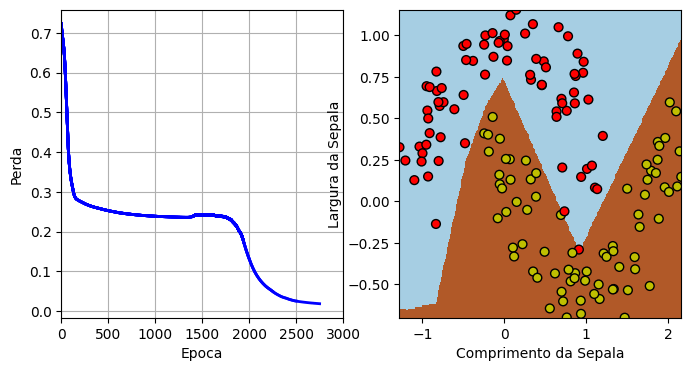

In [ ]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

Final loss: tensor(0.0087)


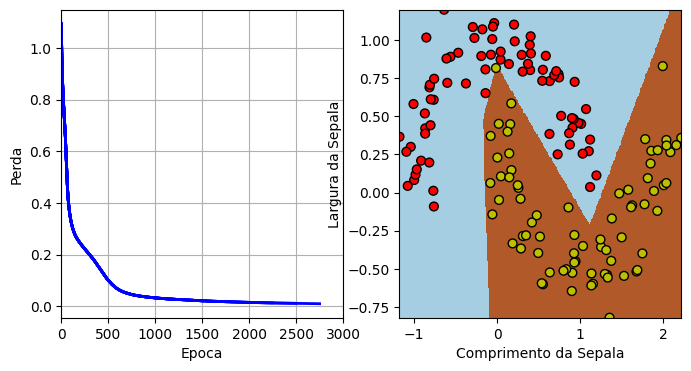

In [ ]:
lr = 0.15

optimizer = torch.optim.SGD(model2.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model2, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model2(X_tensor)

    loss = criterion(output, Y_tensor)

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [ ]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([5, 2])
tensor([[ 2.1998,  0.2067],
        [-3.1580, -0.2138],
        [ 0.1535, -0.2444],
        [ 0.7658,  1.4137],
        [ 1.3436,  0.9976]])
dense.0.bias    torch.Size([5])
tensor([-2.4129,  0.1302, -0.4986, -0.0849, -0.4261])
dense.2.weight  torch.Size([5, 5])
tensor([[ 0.0549,  0.4965, -0.3431, -0.0241, -0.2931],
        [-1.5531,  1.9683, -0.2867,  1.3736,  0.7247],
        [ 2.5965, -1.9668, -0.4403, -0.2065, -1.1057],
        [-0.9670,  1.4519,  0.1969,  0.7173,  1.0552],
        [-0.3788,  0.2497,  0.0293, -0.3069, -0.1246]])
dense.2.bias    torch.Size([5])
tensor([-0.2625, -0.3660,  1.8360, -0.3675, -0.3654])
dense.4.weight  torch.Size([3, 5])
tensor([[ 0.4289,  2.4561, -2.3821,  1.8444, -0.1601],
        [-0.3417, -1.5285,  3.0698, -1.0610,  0.0506],
        [-0.3169, -0.3812, -0.3045, -0.1541, -0.3309]])
dense.4.bias    torch.Size([3])
tensor([ 0.1986,  2.0551, -2.3461])


### Avaliação do classificador

In [ ]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  1.0


### Matriz de confusão

In [ ]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,75,0
1,0,75


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.
2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.
3. O que ocorre quando não se utiliza ativação não linear entre camadas?

**1 - Atingir 100% de acurácia no conjunto de treinamento através da expansão da capacidade do modelo (neurônios/camadas) é um forte indicativo de sobreajuste (overfitting). Embora o modelo memorize perfeitamente o dataset de treino, sua capacidade de generalização para dados não vistos é comprometida, o que exige a implementação de técnicas de regularização (ex: Dropout) ou a redução da complexidade da arquitetura.**

**2 - Substituição da Ativação (ReLU → Sigmoid): A substituição da ReLU pela função Sigmoid resultou em uma degradação notável da acurácia. Este efeito é classicamente atribuído ao problema do gradiente decrescente (vanishing gradient). Nas regiões de saturação da Sigmoid, o gradiente de erro se torna quase nulo, dificultando a atualização eficiente dos pesos durante o backpropagation e paralisando o aprendizado das camadas iniciais.**

**3 - Remoção da Ativação Não Linear: A ausência de funções de ativação não lineares (como ReLU) reduz a rede multicamadas a uma simples transformação linear. Matematicamente, a composição de qualquer número de operações lineares resulta em uma única função linear. Consequentemente, a rede perde a capacidade de aprender e mapear padrões não lineares e complexos inerentes ao problema, limitando-se a tarefas de separação linear e resultando em baixa performance e sub-otimização.**

## Principais aprendizados

**Capacidade e Regularização: O ajuste excessivo de hiperparâmetros (como o número de neurônios) aumenta o risco de overfitting e eleva o custo computacional. É vital equilibrar a capacidade do modelo com o uso de regularização para garantir a generalização.**

**Funções de Ativação: A escolha da função de ativação é fundamental para introduzir a não linearidade necessária. A ReLU é preferível em camadas ocultas por mitigar o vanishing gradient e acelerar a convergência do treinamento.**